## Classification on the `Data Science London + Scikit-learn` Competition (Late Entry)

In [2]:
# Import necessary libraries/packages, modules, classes
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
SVC_Kernels = ['linear','polynomial','rbf','sigmoid']

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 2.6 MB/s eta 0:00:38
   ---------------------------------------- 0.2/99.8 MB 2.4 MB/s eta 0:00:42
   ---------------------------------------- 0.4/99.8 MB 2.8 MB/s eta 0:00:36
   ---------------------------------------- 0.5/99.8 MB 2.7 MB/s eta 0:00:37
   ---------------------------------------- 0.6/99.8 MB 2.7 MB/s eta 0:00:37
   ---------------------------------------- 0.8/99.8 MB 2.7 MB/s eta 0:00:37
   ---------------------------------------- 0.9/99.8 MB 2.8 MB/s eta 0:00:35
   ---------------------------------------- 1.1/99.8 MB 2.9 MB/s eta 0:00:35
    ---------------------------

### Create Dataframes using Pandas
I'm going to have a training set and validation set, which will pull data both from the `train.csv` file

In [3]:
# Create dataframes of the provided data
x_trainval = pd.read_csv('data/train.csv', header=None)
y_trainval = pd.read_csv('data/trainLabels.csv', header=None)
y_trainval = y_trainval.squeeze()
x_test = pd.read_csv('data/test.csv', header=None)

#### Kaggle Data Description & Validation of Dataframes
This is what the description of the data is on the Kaggle website:

*"This is a synthetic data set of 40 features, representing objects from two classes (labeled as 0 or 1). The training set has 1000 samples and the testing set has 9000."*

I'll have a quick set of assertions to make sure this is what I'm expecting, and alsot that the features are contained in a Dataframe while the targets are a Series.

In [4]:
# Confirm dataframes have the expected shapes and types
print('Training/Validation Features Shape:',x_trainval.shape,'of type',type(x_trainval))
assert x_trainval.shape == (1000,40), "x_trainval should be of shape (1000,40)"
assert type(x_trainval) == type(pd.DataFrame()), 'x_trainval should be of type pandas.core.frame.DataFrame'
print('Training/Validation Labels Shape:',y_trainval.shape,'of type',type(y_trainval))
assert y_trainval.shape == (1000,), "y_trainval should be of shape (1000,)"
assert type(y_trainval) == type(pd.Series()), 'y_trainval should be of type pandas.core.series.Series'
print('Test Features Shape:',x_test.shape,'of type',type(x_test))
assert x_test.shape == (9000,40), "X_test should be of shape (9000,40)"
assert type(x_test) == type(pd.DataFrame()), 'x_test should be of type pandas.core.frame.DataFrame'
num_feat = x_trainval.shape[1]

Training/Validation Features Shape: (1000, 40) of type <class 'pandas.core.frame.DataFrame'>
Training/Validation Labels Shape: (1000,) of type <class 'pandas.core.series.Series'>
Test Features Shape: (9000, 40) of type <class 'pandas.core.frame.DataFrame'>


## EDA

I'll start just by looking at the data generally, using both `info` and `describe` methods:

In [5]:
x_trainval.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.025596,-0.024526,-0.024088,-0.002271,1.092329,-0.006250,0.497342,-0.037883,0.026391,-0.003597,...,0.030651,0.022951,-0.542491,-0.011608,-0.483507,0.033371,0.567185,0.006849,-0.892659,0.609451
std,1.008282,1.016298,0.979109,0.970575,4.538834,0.989128,2.118819,2.232256,1.001064,1.013520,...,1.011645,1.001375,2.239939,1.022456,2.121281,1.007044,2.227876,0.997635,2.022022,2.045439
min,-3.365711,-3.492086,-2.695602,-3.460471,-16.421901,-3.041250,-7.224761,-6.509084,-3.145588,-2.749812,...,-3.379194,-2.971125,-7.840890,-2.999564,-7.124105,-2.952358,-5.452254,-3.473913,-8.051722,-7.799086
25%,-0.669010,-0.693937,-0.698830,-0.617557,-1.801997,-0.732265,-0.838619,-1.604037,-0.677562,-0.682220,...,-0.659457,-0.696032,-2.121943,-0.664550,-1.879247,-0.642861,-1.059786,-0.691162,-2.220126,-0.565041
50%,0.027895,-0.033194,0.008145,0.002327,0.862818,0.027041,0.582321,0.018809,0.022092,-0.036110,...,0.049416,0.049778,-0.568262,-0.028097,-0.493575,0.037732,0.455474,0.038284,-0.855470,0.779944
75%,0.762520,0.682753,0.661434,0.640743,3.843172,0.671456,1.913664,1.438304,0.741310,0.665364,...,0.747031,0.699917,0.939348,0.651374,1.005795,0.691800,2.122157,0.693535,0.388698,1.992193
max,3.326246,3.583870,2.546507,3.088738,17.565345,3.102997,7.592666,7.130097,3.145258,3.919426,...,2.844792,3.688047,7.160379,3.353631,6.005818,3.420561,6.603499,3.492548,5.774120,6.803984


In [6]:
x_trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

Nothing too out of the ordinary, and it also looks like there is not missing data:

In [8]:
print('Number of missing values:',x_trainval.isna().sum().sum())

Number of missing values: 0


Since we'll be doing predicitn of binary classes, and since the number of features is fairly small, I'll skip multivariate analysis for correlations.  I'll just look at the distribution of the values in each feature:

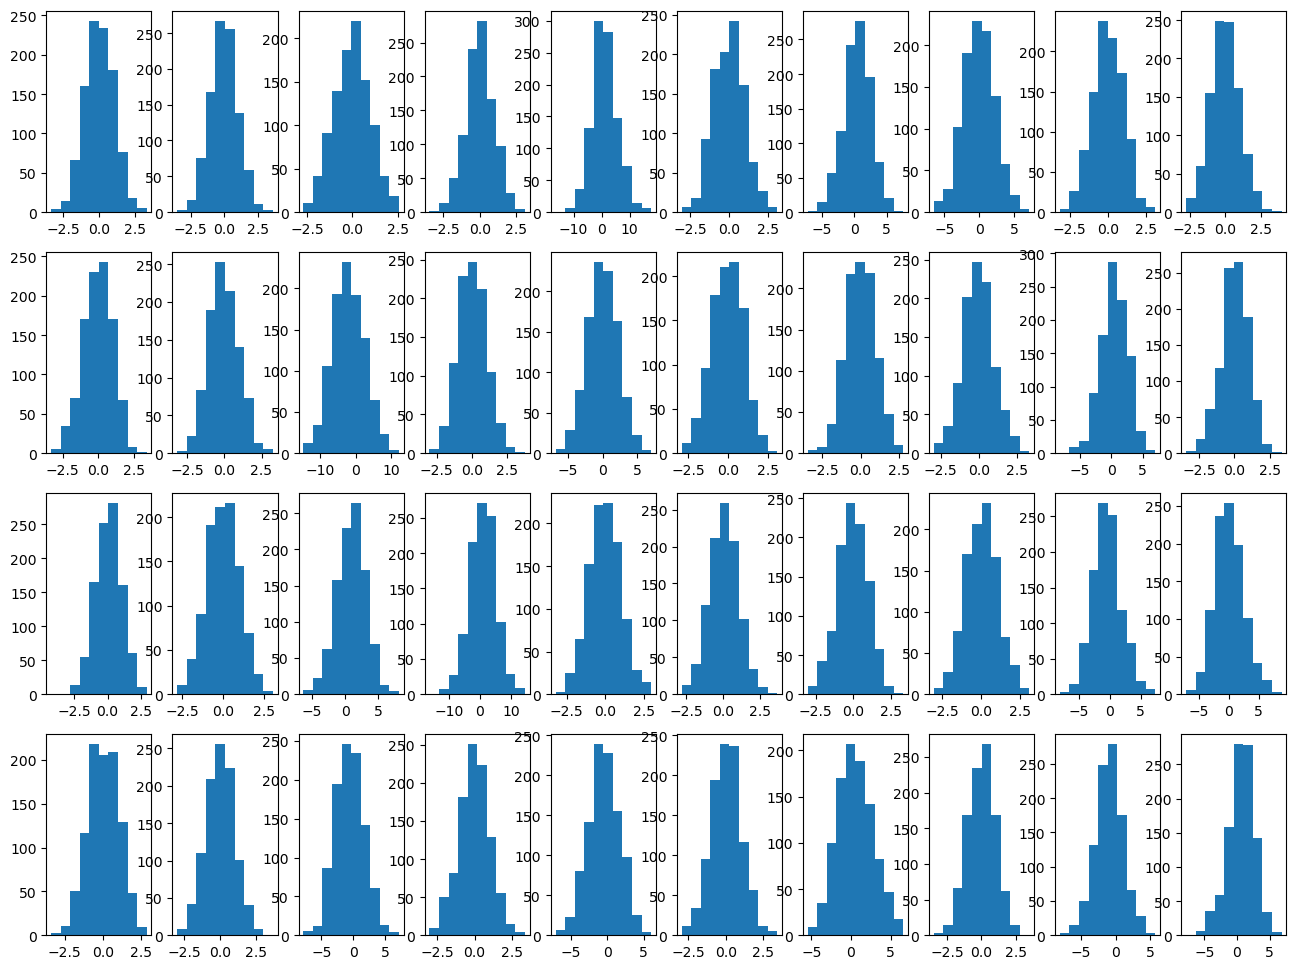

In [9]:
hor_plots = 4
vert_plots = 10
plt.figure(figsize=(16,12))

col = 0
for vert_plot in range(vert_plots):
    for hor_plot in range(hor_plots):
        if col < 40:
            plt.subplot(hor_plots,vert_plots,col+1)
            plt.hist(x_trainval[col], bins=10)
            col += 1

Distributions all look normal.  I'm going to move on to developing models and training them on the data.

### Modeling Selection, Training, and Evaluation

I'll first divide up our training set into the training and validation sets:

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=123)

Quick sanity check to make sure the indices in my training sets, for features and targets, are completely identical

In [11]:
all(x_train.index == y_train.index)

True

I'm going to use GridSearchCV to help pick the optimal parameters of my models.  First, I'll want to scale the data.  For the fun of it, I'm going to try three different approaches-- the "standard" ones-- and save them into a list to later add to a list of pipelines to run through GridSearchCV.

In [12]:
# Initialize scalers
scaler_mm = MinMaxScaler()
scaler_abs = MaxAbsScaler()
scaler_std = StandardScaler()
scalers = [scaler_mm, scaler_abs, scaler_std]

I'm going to use a number of classifier models.  The most common classifiers from sklearn will be used, as well as XGBoost

In [13]:
# Initialize classifiers
dummy = DummyClassifier()
knn = KNeighborsClassifier()
ridge = RidgeClassifier()
gnb = GaussianNB()
svc = SVC()
tree = DecisionTreeClassifier()
randfor = RandomForestClassifier()
gbdt = GradientBoostingClassifier()
neural = MLPClassifier()
xgb = XGBClassifier()
classifiers = [dummy,knn,ridge,gnb,svc,tree,randfor,gbdt,neural,xgb]
classifiers_types = [str(clf) for clf in classifiers]

I'll add in PCA() after scaling, and build a list of pipelines for each combination of scaler and classifier.

In [14]:
# Iterate through the classifiers and scalers to create a list of pipelines
pipes = []
for clf in classifiers:
    for scaler in scalers:
        pipes.append(
            Pipeline(steps=
                [('scaler', scaler),
                 ('pca', PCA()),
                 ('clf', clf)]
            )
        )

I'll define the values to search through.  I'll do a couple of options for n_components for the pca layer, and I'll pick a few different options for what I think are the most influential parameters of each classifier.

In [15]:
# Define the dictionaries for each classifier model
dummy_params = {'pca__n_components':[10, 40],
                'clf__strategy':['most_frequent', 'prior', 'stratified', 'uniform', 'constant']}
knn_params = {'pca__n_components':[10, 40],
              'clf__n_neighbors':[3,4,7,9]}
ridge_params = {'pca__n_components':[10, 40],
                'clf__alpha':[0.01,0.1,1],'clf__solver':['lbfgs', 'cholesky', 'sparse_cg', 'auot']}
gnb_params = {'pca__n_components':[10, 40]}
svc_params = {'pca__n_components':[10, 40],
              'clf__kernel':['linear','polynomial','rbf','sigmoid'],'clf__gamma': [0.1, 1, 10, 100],'clf__C':[0.1, 1, 10, 100]}
tree_params = {'pca__n_components':[10, 40],
               'clf__max_depth':[2, 3, 4, 5, 6]}
randfor_params = {'pca__n_components':[10, 40],
                  'clf__max_features':list(range(num_feat-2,num_feat+2,1)), "clf__n_estimators":[10,25,50,100]}
gbdt_params = {'pca__n_components':[10, 40],
               'clf__learning_rate':[0.001,0.01,0.1], 'clf__max_depth':[2,4,8,20,50]}
neural_params = {'pca__n_components':[10, 40],
                 'clf__activation':['identity','logistic','tanh','relu']}
neural_params = {'pca__n_components':[10, 40],
                 'clf__activation':['identity','logistic','tanh','relu']}
xgb_params = {'pca__n_components':[10, 40],
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [2,10],
    'clf__gamma': [0.01, 0.1]
  }
params_grids = [dummy_params,knn_params,ridge_params,gnb_params,
                svc_params,tree_params,randfor_params,gbdt_params,neural_params,xgb_params]
clf_params = dict(zip(classifiers_types,params_grids))

Now I'll iterate through the list of pipes, using the best pipe combo from the training to score on the validation data, saving the best pipe as the one I'll use for test data.

In [16]:
# Setup gridsearchcv parameters.
# Three folds
cv=3
best_val_score = 0
best_pipe = None
for pipe in pipes:
    scaler_type = str(pipe.steps[0][1])
    pca_type = str(pipe.steps[1][1])
    clf_type = str(pipe.steps[2][1])
    params_grid = clf_params[clf_type]
    print('Starting:')
    print('Scaler:',scaler_type)
    print('Classifier:',clf_type)
    grid = GridSearchCV(pipe, param_grid=params_grid, scoring='accuracy',cv=cv,n_jobs=-1).fit(x_train, y_train)
    print('Best (Training) Params:', grid.best_params_)
    print('Best (Training) Estimator:', grid.best_estimator_)
    print('Best (Training) Score:', grid.best_estimator_.score(x_train, y_train))
    print('Validation Score:',grid.best_estimator_.score(x_val,y_val),'\n')
    val_score = grid.best_estimator_.score(x_val,y_val)
    # Save the best version on the validation data
    if val_score > best_val_score:
        best_val_score = val_score
        best_pipe = grid.best_estimator_

Starting:
Scaler: MinMaxScaler()
Classifier: DummyClassifier()
Best (Training) Params: {'clf__strategy': 'uniform', 'pca__n_components': 40}
Best (Training) Estimator: Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=40)),
                ('clf', DummyClassifier(strategy='uniform'))])
Best (Training) Score: 0.49125
Validation Score: 0.53 

Starting:
Scaler: MaxAbsScaler()
Classifier: DummyClassifier()
Best (Training) Params: {'clf__strategy': 'uniform', 'pca__n_components': 10}
Best (Training) Estimator: Pipeline(steps=[('scaler', MaxAbsScaler()), ('pca', PCA(n_components=10)),
                ('clf', DummyClassifier(strategy='uniform'))])
Best (Training) Score: 0.49375
Validation Score: 0.44 

Starting:
Scaler: StandardScaler()
Classifier: DummyClassifier()
Best (Training) Params: {'clf__strategy': 'stratified', 'pca__n_components': 10}
Best (Training) Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('clf', Du

Best (Training) Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'pca__n_components': 10}
Best (Training) Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('clf', GradientBoostingClassifier(max_depth=4))])
Best (Training) Score: 0.95625
Validation Score: 0.785 

Starting:
Scaler: MinMaxScaler()
Classifier: MLPClassifier()
Best (Training) Params: {'clf__activation': 'relu', 'pca__n_components': 40}
Best (Training) Estimator: Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=40)),
                ('clf', MLPClassifier())])
Best (Training) Score: 0.985
Validation Score: 0.885 

Starting:
Scaler: MaxAbsScaler()
Classifier: MLPClassifier()
Best (Training) Params: {'clf__activation': 'relu', 'pca__n_components': 40}
Best (Training) Estimator: Pipeline(steps=[('scaler', MaxAbsScaler()), ('pca', PCA(n_components=40)),
                ('clf', MLPClassifier())])
Best (Training) Score: 0.99875
Validation Score: 0.88

Let's look at the "winner":

In [17]:
print('Best score on validation data:',best_val_score)
print('Best pipe',best_pipe)

Best score on validation data: 0.89
Best pipe Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=40)),
                ('clf', SVC(C=10, gamma=1))])


Looks like the best version was our Support Vector Classifier with `C` equal to 10 and `gamma` equal to 1.  This version used the MinMaxScaler and PCA utilized 40 components.  The best score on the validation set isn't amazing, but it's not bad either.  

We'll fit the full training/validation data on this model so it's as ready as it can be for the test feature set.

In [18]:
best_pipe.fit(x_trainval,y_trainval)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=40)),
                ('clf', SVC(C=10, gamma=1))])

### Predict & Save

Good luck, dude!

In [19]:
# Make predictions and put into a Dataframe
best_pred = pd.DataFrame(best_pipe.predict(x_test))
# Adjust the format slightly to match what was requested
best_pred.columns = ['Solution']
best_pred.reset_index(inplace=True)
best_pred.rename(columns={'index':'Id'},inplace=True)
best_pred.set_index('Id',inplace=True)
# Saving predictions to CSV
best_pred.to_csv('Submission.csv')